In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Add the directory to Python path
import sys
sys.path.append('/content/drive/MyDrive')

Mounted at /content/drive


In [ ]:
%run /content/drive/MyDrive/DeepONet/utils/deeponet_lib.ipynb

Using cpu device


## 3. Darcy flow (infinite dimensional parameter)


Consider a simplified Darcy flow model featuring a spatially distributed parameter (permeability field), namely

$$\begin{cases}-\nabla\cdot(k\nabla p) = f & \text{in}\;\Omega\\-\nabla p\cdot\boldsymbol{n}\equiv0 & \text{on}\;\partial\Omega\\\int_{\Omega}p=0\end{cases}$$

where $\Omega\subset\mathbb{R}^{2}$ is the spatial domain, $p:\Omega\to\mathbb{R}$ is the pressure field and $\boldsymbol{n}$ is the unit normal. The permeability field, $k:\Omega\to(0,+\infty)$ is our parameter. We model it using a random field for which

$$0.1\le k \le 10.1,\quad\quad k\in\mathcal{C}(\Omega),$$

holds $\mathbb{P}$-almost surely. Specifically, we derive the latter as

$$k = 10\mathcal{S}(D e^{-\gamma Z})+0.1$$

where

- $\gamma=1/4$,
- $D:\Omega\to[0,+\infty)$ is a deterministic map, related to the "point-to-boundary-distance",
- $Z$ is a centered Gaussian random field with isotropic covariance kernel $\kappa(r)=e^{-100r^2}$,
- $\mathcal{S}$ is a scaling operator. Precisely, if $g\in\mathcal{C}(\Omega)$ is nonconstant, then $\mathcal{S}(g)$ is defined as

$$\mathcal{S}(g):=\frac{g-\min_{\boldsymbol{x}\in\Omega}g(\boldsymbol{x})}{\max_{\boldsymbol{x}\in\Omega}g(\boldsymbol{x})-\min_{\boldsymbol{x}\in\Omega}g(\boldsymbol{x})}.$$

We are interested in learning the map

$$k\mapsto p,$$

that maps the permeability field onto the corresponding pressure field. Here, as a spatial domain $\Omega$ we consider the Elba Island. As a source term, instead, we consider a superposition of three pointwise sources (of fixed position and intensity),

$$f = \sum_{i=1}^{3}\delta_{\boldsymbol{x}_i},$$

where $\delta_{\boldsymbol{x}_i}$ denotes the Dirac delta at $\boldsymbol{x}_i$.

In [ ]:
k, pressure = load_data(id = "1Fx0BJbggyoFS344kEsl3M2QroLYg2Cp1")

Downloading...
From (original): https://drive.google.com/uc?id=1Fx0BJbggyoFS344kEsl3M2QroLYg2Cp1
From (redirected): https://drive.google.com/uc?id=1Fx0BJbggyoFS344kEsl3M2QroLYg2Cp1&confirm=t&uuid=0c7c1262-7cdf-44e6-9299-0a5b632fef76
To: /content/data.npz
100%|██████████| 153M/153M [00:02<00:00, 62.7MB/s]


In [ ]:
k.shape, pressure.shape

((1000, 9550), (1000, 9550))

In [ ]:
gdown.download(id = "16n2zKU9xjhO0LY5Ddeov0DXTfJaO4oV4", output = "elba_mesh.xml")
mesh = fe.loadmesh("elba_mesh.xml")
Vh, y = get_fem_space(mesh)

Downloading...
From (original): https://drive.google.com/uc?id=16n2zKU9xjhO0LY5Ddeov0DXTfJaO4oV4
From (redirected): https://drive.google.com/uc?id=16n2zKU9xjhO0LY5Ddeov0DXTfJaO4oV4&confirm=t&uuid=b69aceba-4c78-42c2-ade9-26128b274eb3
To: /content/elba_mesh.xml
100%|██████████| 1.93M/1.93M [00:00<00:00, 96.9MB/s]

Calling FFC just-in-time (JIT) compiler, this may take some time.



Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.018877 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.570838 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:-----------------------------

In [ ]:
# Define loss function
loss_function = mse_loss
error_metric = error_metric

In [ ]:
# Define the mesh
ymesh = dv.tensor(fe.coordinates(Vh))

# Config
learning_rate = 1e-3
batch_size = 1
epochs = 50

d = ymesh.shape[1]
p = 15
h = 100

In [ ]:
nsensors = [20, 50, 90, 150, 230, 350, 500]
trainers = []

for n in nsensors:
  print(n)

  sensors = np.linspace(0, Vh.dim(), n+1).astype('int')[:-1]
  ksens = k[:, sensors]

  # Config
  m = n

  # Build the model
  model = DeepONet(m,d,p,h)
  model.to(device)

  # Define optimization strategy
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

  # Build the dataset
  train_size = 800
  val_size = 50

  dataset = FomDataset(ksens, pressure, ymesh)
  train_set, val_set, test_set = train_val_test_split(dataset, train_size, val_size)

  train_loader = DataLoader(train_set, batch_size = batch_size)
  val_loader = DataLoader(val_set, batch_size = batch_size)
  test_loader =  DataLoader(test_set, batch_size = batch_size)

  # Train the model
  trainer = Trainer(train_loader, val_loader, test_loader, model, loss_function, optimizer, epochs, error_metric)
  train_hist, val_hist, test_hist = trainer.fit()
  trainers.append(trainer)

20


<ipython-input-2-9a8cb204c24c>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32).to(device)


Epoch 1/50:
Current Loss: 0.070485  [  741/  750]
Train Loss: 0.0253 | Val Loss: 0.0149 | Test Loss: 0.0140
Epoch 2/50:
Current Loss: 0.060399  [  741/  750]
Train Loss: 0.0134 | Val Loss: 0.0123 | Test Loss: 0.0118
Epoch 3/50:
Current Loss: 0.050484  [  741/  750]
Train Loss: 0.0102 | Val Loss: 0.0097 | Test Loss: 0.0091
Epoch 4/50:
Current Loss: 0.042297  [  741/  750]
Train Loss: 0.0080 | Val Loss: 0.0083 | Test Loss: 0.0078
Epoch 5/50:
Current Loss: 0.037441  [  741/  750]
Train Loss: 0.0066 | Val Loss: 0.0081 | Test Loss: 0.0071
Epoch 6/50:
Current Loss: 0.037717  [  741/  750]
Train Loss: 0.0059 | Val Loss: 0.0072 | Test Loss: 0.0063
Epoch 7/50:
Current Loss: 0.036185  [  741/  750]
Train Loss: 0.0054 | Val Loss: 0.0072 | Test Loss: 0.0062
Epoch 8/50:
Current Loss: 0.026519  [  741/  750]
Train Loss: 0.0052 | Val Loss: 0.0069 | Test Loss: 0.0057
Epoch 9/50:
Current Loss: 0.025058  [  741/  750]
Train Loss: 0.0047 | Val Loss: 0.0064 | Test Loss: 0.0055
Epoch 10/50:
Current Loss: 0

In [ ]:
from matplotlib import cm
def plot_comparison_mre_all(trainers, sensor_counts=None):
    plt.figure(figsize=(8, 5))
    num_models = len(trainers)

    # Viridis colormap (smooth, readable)
    colors = cm.viridis(np.linspace(0, 1, num_models))

    # Line styles to cycle through
    line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 1)), (0, (1, 1))]

    for i, trainer in enumerate(trainers):
        test_hist = trainer.test_hist.get('error_metric', None)
        if test_hist is None:
            print(f"Warning: Trainer {i} has no 'error_metric' in test_hist.")
            continue

        label = f"Model {i + 1}"
        if sensor_counts is not None:
            label += f" (n_sensor={sensor_counts[i]})"

        style = line_styles[i % len(line_styles)]
        plt.semilogx(test_hist, linestyle=style, label=label, color=colors[i])

    plt.xlabel('Epochs')
    plt.ylabel('MRE')
    plt.ylim(0, 0.6)
    plt.title('Comparison of MRE for All Models')
    plt.legend()
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

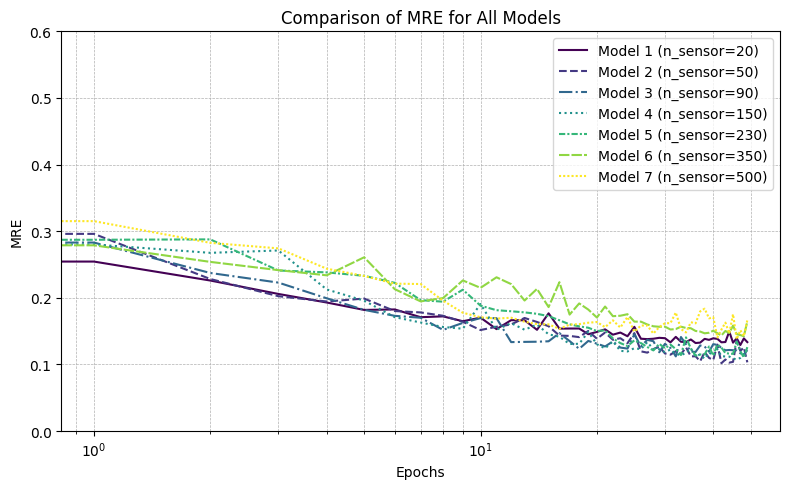

In [ ]:
plot_comparison_mre_all(trainers, sensor_counts=nsensors)